In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from Bio import Phylo


In [2]:
def plot_dendrogram(distance_matrix, labels, linkage="single",
                    truncate_level=-1, figure_size=(20, 15),
                    dpi=300, savefig=False, fig_name="output.png"):
    
    cl = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed',
                                 compute_full_tree=True, linkage=linkage, compute_distances=True)
    cl.fit(distance_matrix)
    
    kwarg = {"truncate_mode": "level", "p": truncate_level, "orientation": "right", "labels": labels}
    
    n_samples = len(cl.labels_)
    counts = np.zeros(cl.children_.shape[0])
    plt.figure(figsize=figure_size, dpi=dpi)
    for i, merge in enumerate(cl.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

        linkage_matrix = np.column_stack(
            [cl.children_, cl.distances_, counts]
        ).astype(float)
        dendrogram(linkage_matrix, **kwarg)
        pass
    
    if savefig is True:
        plt.savefig(fig_name)
        

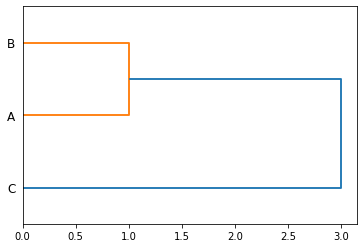

In [12]:
distance = np.array([[0, 1, 4],
                     [0, 0, 3],
                     [0, 0, 0]])
distance += distance.T
plot_dendrogram(distance, ['A', 'B', 'C'], figure_size=None, dpi=None)

In [23]:
cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed',
                                 compute_full_tree=True, linkage="single", compute_distances=True)
cluster.fit(distance)
print(cluster.children_)
print(cluster.distances_)

[[0 1]
 [2 3]]
[1. 3.]
